# Rough Paths - From Quantstart 

* https://www.quantstart.com/articles/rough-path-theory-and-signatures-applied-to-quantitative-finance-part-1/
    
*The article is by Imanol Pérez, a PhD researcher in Mathematics at Oxford University*

**Additional Links:**
* [A Primer on the Signature Method in Machine
Learning](https://arxiv.org/pdf/1603.03788.pdf)
* [Practical Example](https://towardsdatascience.com/predict-bitcoin-prices-by-using-signature-time-series-modelling-cf3100a882cc)

Below is some analysis of Bitcoin using this rough path signature approach

In [77]:
import os
import numpy as np
import pandas as pd
import numba as nb

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from iisignature import *
from sklearn import linear_model
import numbers

In [2]:
import requests
encoding = 'utf-8'

In [23]:
%matplotlib inline
sns.set()

## Define All Classes and Functions

**From Part 1**

In [100]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches

def leadlag(X):
    '''
    Returns lead-lag-transformed stream of X

    Arguments:
        X: list, whose elements are tuples of the form
        (time, value).

    Returns:
        list of points on the plane, the lead-lag
        transformed stream of X
    '''

    l=[]

    for j in range(2*(len(X))-1):
        i1=j//2
        i2=j//2
        if j%2!=0:
            i1+=1
        l.append((X[i1][1], X[i2][1]))

    return l

def plotLeadLag(X, diagonal=True):
    '''
    Plots the lead-laged transformed path X. If diagonal
    is True, a line joining the start and ending points
    is displayed.

    Arguments:
        X: list, whose elements are tuples of the form
        (X^lead, X^lag) diagonal: boolean, default is
        True. If True, a line joining the start and
        ending points is displayed.
    '''
    for i in range(len(X)-1):
        plt.plot([X[i][1], X[i+1][1]], [X[i][0], X[i+1][0]],
                    color='k', linestyle='-', linewidth=2)


    # Show the diagonal, if diagonal is true
    if diagonal:
        plt.plot([min(min([p[0] for p in X]), min([p[1]
                for p in X])), max(max([p[0] for p in X]),
                max([p[1] for p in X]))], [min(min([p[0]
                for p in X]), min([p[1] for p in X])),
                max(max([p[0] for p in X]), max([p[1] for
                p in X]))], color='#BDBDBD', linestyle='-',
                linewidth=1)

    axes=plt.gca()
    axes.set_xlim([min([p[1] for p in X])-1, max([p[1] for
                  p in X])+1])
    axes.set_ylim([min([p[0] for p in X])-1, max([p[0] for
                  p in X])+1])
    axes.get_yaxis().get_major_formatter().set_useOffset(False)
    axes.get_xaxis().get_major_formatter().set_useOffset(False)
    axes.set_aspect('equal', 'datalim')
    plt.show()


def timejoined(X):
    '''
    Returns time-joined transformation of the stream of
    data X

    Arguments:
        X: list, whose elements are tuples of the form
        (time, value).

    Returns:
        list of points on the plane, the time-joined
        transformed stream of X
    '''
    X.append(X[-1])
    l=[]

    for j in range(2*(len(X))+1+2):
        if j==0:
            l.append((X[j][0], 0))
            continue
        for i in range(len(X)-1):
            if j==2*i+1:
                l.append((X[i][0], X[i][1]))
                break
            if j==2*i+2:
                l.append((X[i+1][0], X[i][1]))
                break
    return l

def plottimejoined(X):
    '''
    Plots the time-joined transfomed path X.

    Arguments:
        X: list, whose elements are tuples of the form (t, X)
    '''

    for i in range(len(X)-1):
        plt.plot([X[i][0], X[i+1][0]], [X[i][1], X[i+1][1]],
                color='k', linestyle='-', linewidth=2)

    axes=plt.gca()
    axes.set_xlim([min([p[0] for p in X]), max([p[0] for p
                  in X])+1])
    axes.set_ylim([min([p[1] for p in X]), max([p[1] for p
                  in X])+1])
    axes.get_yaxis().get_major_formatter().set_useOffset(False)
    axes.get_xaxis().get_major_formatter().set_useOffset(False)
    axes.set_aspect('equal', 'datalim')
    plt.show()

**From Part 2**

In [78]:
class SigLearn:

    def __init__(self, order=2, alpha=0.1):
        if not isinstance(order, numbers.Integral) or order<1:
            raise NameError('The order must be a positive integer.')
        if not isinstance(alpha, numbers.Real) or alpha<=0.0:
            raise NameError('Alpha must be a positive real.')
        self.order=int(order)
        self.reg=None
        self.alpha=alpha

    def train(self, x, y):
        '''
        Trains the model using signatures.
        
        x: list of inputs, where each element of
            the list is a list of tuples.
        y: list of outputs.
        '''

        # We check that x and y have appropriate types
        if x is None or y is None:
            return
        if not (type(x) is list or type(x) is tuple) or not (type(y) is list or type(y) is tuple):
            raise NameError('Input and output must be lists or tuples.')
        if len(x)!=len(y):
            raise NameError('The number of inputs and the number of outputs must coincide.')
        ###
        
        X=[list(sig(np.array(stream), self.order)) for stream in x]
        self.reg = linear_model.Lasso(alpha = self.alpha)
        self.reg.fit(X, y)

    def predict(self, x):
        '''
        
        Predicts the outputs of the inputs x using the the
        pre-trained model.
        
        x: list of inputs, where each element of
            the list is a list of tuples.

        Returns:

        list of predicted outputs.
        
        '''
        if self.reg is None:
            raise NameError('The model is not trained.')

        X=[list(sig(np.array(stream), self.order)) for stream in x]
 
        return self.reg.predict(X)

In [7]:
def accuracy(predictions, y):
    p=0
    for i in range(len(y)):
        if round(predictions[i])==y[i]:
            p+=1

    return p/float(len(y))

## Test Function With Digits Example

In [4]:
class Digit:
    def __init__(self, points, digit):
        self.points=points
        self.digit=digit

def loadDigits(path):
    data = requests.get(path).content.decode(encoding)
    # data = http.request('GET', path)
    # data = BeautifulSoup(data.data.decode('utf-8'))
    digits=[]
    # print(data)
    for line in data.splitlines():
        # print(line)
        digitList= line.replace(",", " ").replace("\n", "").split()
        number=float(digitList[16])
        points=np.array([[float(digitList[i]), float(digitList[i+1])]
                        for i in range(0,len(digitList)-1, 2)])
        digit=Digit(points, number)
        digits.append(digit)
    
    return digits
    # return data

trainingPath="https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
trainingSet=loadDigits(trainingPath)
inputs=[digit.points for digit in trainingSet]
outputs=[digit.digit for digit in trainingSet]

In [17]:
model=SigLearn(order=10, alpha = 0.1)
model.train(inputs, outputs)

/Users/reubenthomaskade/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [10]:
testingPath="https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes"
testingSet=loadDigits(testingPath)

testingInputs=[digit.points for digit in testingSet]
testingOutputs=[digit.digit for digit in testingSet]

predictions=model.predict(testingInputs)

In [19]:
accuracy(predictions, testingOutputs)

0.548885077186964

## Apply this to bitcoin data

### Load Bitstamp Btc data

In [24]:
# Note this is sourced from: http://api.bitcoincharts.com/v1/csv/
# See SO post for more detail: https://stackoverflow.com/questions/16143266/get-bitcoin-historical-data

downloads_path = os.path.expanduser('~/Downloads')
btc_data = pd.read_csv(os.path.join(downloads_path, "bitstampUSD.csv"), header=None)
btc_data.columns = ["TimeStamp", "Price", "Volume"]

In [25]:
start_date = "2020-02-28"
end_date = "2020-03-07"

In [26]:
btc_data['TimeStamp'] = pd.to_datetime(btc_data['TimeStamp'], unit='s')
btc_data.set_index("TimeStamp", inplace=True)
btc_data = btc_data.loc[(btc_data.index > start_date) & (btc_data.index <= end_date)]

In [27]:
btc_data.index.is_all_dates

True

**Get Volume Bars**

In [28]:
# %%time
vol_amount = 50
vol_data = pd.DataFrame()
btc_data['volcum'] = btc_data['Volume'].cumsum()
btc_data['volcumgrp'] =  (btc_data['volcum'] // vol_amount).astype(int)

# Group by minute and get OHLC
grp_btc_data = btc_data.reset_index().groupby("volcumgrp")
vol_data["volume"] = grp_btc_data["Volume"].sum()
vol_data["open"] = grp_btc_data["Price"].nth(0)
vol_data["high"] = grp_btc_data["Price"].max()
vol_data["low"] = grp_btc_data["Price"].min()
vol_data["close"] = grp_btc_data["Price"].nth(-1)
vol_data["last_time"] = grp_btc_data["TimeStamp"].max()

In [30]:
vol_data.shape

(756, 6)

In [31]:
vol_data.head()

,volume,open,high,low,close,last_time
volcumgrp,,,,,,
0,49.623477,8816.50,8823.63,8782.14,8796.44,2020-02-28 00:09:43
1,45.465628,8805.54,8820.07,8792.50,8817.99,2020-02-28 00:17:24
2,54.727204,8820.06,8855.85,8809.33,8855.85,2020-02-28 00:26:38
3,49.889667,8852.97,8890.99,8847.23,8886.24,2020-02-28 00:31:46
4,49.978621,8886.36,8900.94,8872.43,8872.43,2020-02-28 00:34:41


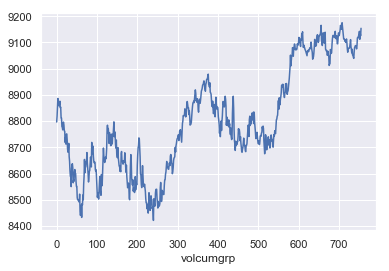

In [32]:
vol_data.close.plot()

## Run Lead-Lag Transformation

This is done on the volume bars

In [50]:
# Only look at first 100 bars
X_rp = leadlag(list(vol_data.close.iteritems()))

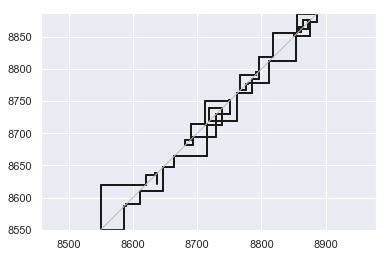

In [52]:
# Only Plot First 80 Obs
plotLeadLag(X_rp[0:80])

### Define Signature for Price Change

In [85]:
# Note the price change is Half the length of the signature
# This is due to the signature being 2x the legnth of the original series
step = 10

pct_chng_vec = vol_data.close.pct_change(step // 2)

tst_inputs = []
tst_outputs = []

# So we get the signature for n steps
# And then see if we can observe the if the price change was positive or negative for next n / 2 steps
for i in range(step, len(X_rp), step):
    j = i // 2 + step // 2
    if j > pct_chng_vec.shape[0]:
        break
    sg = np.array(X_rp[i-10:i]) # don't use var name sig ... trust me
    is_up = 1 if pct_chng_vec[j] > 0 else 0
    tst_inputs.append(sg)
    tst_outputs.append(is_up)

In [89]:
model = SigLearn(order=10, alpha = 0.1)
model.train(tst_inputs[0:100], tst_outputs[0:100])

/Users/reubenthomaskade/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [90]:
predictions=model.predict(tst_inputs[-45:]) # leave a 15 bar buffer

In [91]:
accuracy(predictions, tst_outputs[-45:])

0.7111111111111111

**With this accuracy probably have some serious look-ahead bias!**

## Run Time-Joined Transformation

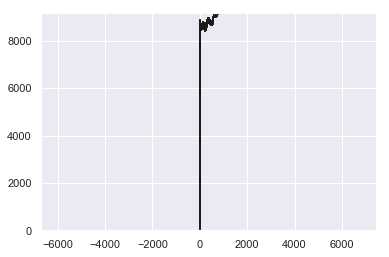

In [102]:
# Only look at first 100 bars
X_tj = timejoined(list(vol_data.close.iteritems()))
# Only Plot First 80 Obs
plottimejoined(X_tj)

### Define Signature for Price Change

In [106]:
# Note the price change is Half the length of the signature
# This is due to the signature being 2x the legnth of the original series
step = 10

pct_chng_vec = vol_data.close.pct_change(step // 2)

tj_tst_inputs = []
tj_tst_outputs = []

# So we get the signature for n steps
# And then see if we can observe the if the price change was positive or negative for next n / 2 steps
for i in range(step, len(X_tj), step):
    j = i // 2 + step // 2
    if j > pct_chng_vec.shape[0]:
        break
    sg = np.array(X_tj[i-10:i]) # don't use var name sig ... trust me
    is_up = 1 if pct_chng_vec[j] > 0 else 0
    tj_tst_inputs.append(sg)
    tj_tst_outputs.append(is_up)

In [107]:
model = SigLearn(order=10, alpha = 0.1)
model.train(tj_tst_inputs[0:100], tj_tst_outputs[0:100])

/Users/reubenthomaskade/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [108]:
predictions=model.predict(tj_tst_inputs[-45:]) # leave a 15 bar buffer

In [109]:
accuracy(predictions, tj_tst_outputs[-45:])

0.5555555555555556